In [46]:
# TODO: None of this has been tested as I didn't get the chance to export data from the processing_test file.
import subprocess
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Polygon, MultiPolygon

In [2]:
def get_git_root():
    try:
        root_dir = (
            subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
            .strip()
            .decode("utf-8")
        )
        return root_dir
    except subprocess.CalledProcessError:
        raise Exception("This is not a Git repository")


# Get the Git repository's root directory
repo_root = get_git_root()
subfolder='data'
###FIXME: Maybe better folders for the data, the file_paths would need to be changed in that case
file_path = os.path.join(repo_root, subfolder, "SNGE8RFL.shp")
gps_df=gpd.read_file(file_path)

In [3]:
###Calculate the wealth index average for each cluster with weights based on the household sample weight
household_wealth_index_df=pd.read_csv(os.path.join(repo_root, "Wealth_Index_DF.csv"))
def weighted_average(values, weights):
    return np.average(values, weights=weights) 

cluster_wealth=household_wealth_index_df.groupby('hv001').apply(
    lambda x:pd.Series({'wealth_index':weighted_average(x['wealth_index'],x['hv005'])})
).reset_index()

C:\Users\worbo\AppData\Local\Temp\ipykernel_17108\1627577868.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_wealth=household_wealth_index_df.groupby('hv001').apply(


In [4]:
gps_dfmerged=pd.merge(gps_df, cluster_wealth,left_on='DHSCLUST',right_on='hv001',how='right') #Adding the wealth index to the gps data


In [5]:
senegal_filepath=os.path.join(repo_root, subfolder,'Senegal_Shapefile', "gadm41_SEN_0.shp")
senegal_boundary=gpd.read_file(senegal_filepath)

In [103]:
###Creating the geometry and the dataframe that includes the geometry
geometry=[Point(xy) for xy in zip(gps_dfmerged['LONGNUM'],gps_dfmerged['LATNUM'])]
gdf=gpd.GeoDataFrame(gps_dfmerged,geometry=geometry)
senegal_boundary = senegal_boundary.to_crs(gdf.crs)
gdf = gdf.to_crs(epsg=32628)###Converting to UTM for buffer creation

###adding a buffer based on ubran or rural
def create_errorbounds(row):
    if row["URBAN_RURA"]=='U':
        return row['geometry'].buffer(2000)
    elif row["URBAN_RURA"]=='R':
        return row['geometry'].buffer(10000)
    else:
        print(f"Error, can't determine urban or rural for row {row}. Exiting")
        exit()

gdf['buffer']=gdf.apply(create_errorbounds,axis=1)
buffer_gdf = gpd.GeoDataFrame(gdf[["buffer"]], geometry="buffer", crs="EPSG:32628")
buffer_gdf = buffer_gdf.to_crs(epsg=4326)
gdf["buffer"] = buffer_gdf["buffer"]
gdf['buffer']=gdf['buffer'].to_crs(epsg=4326)###Converting back to WGS84 for plotting
gdf = gdf.to_crs(epsg=4326)###Converting back to WGS84 for plotting

###Clipping the buffer to the Senegal boundary
gdf_clipped=gdf['buffer'].clip(senegal_boundary)
gdf['buffer']=gdf_clipped
###For overlapping regions, averaging the wealth index
gdf['wealth_index']=gdf.groupby('buffer')['wealth_index'].transform('mean')
gdf = gdf.drop(columns=["geometry"])
gdf['hv005']=household_wealth_index_df['hv005']
gdf.set_geometry("buffer", inplace=True)

In [104]:
def handle_overlaps(gdf, column):
    new_rows = []
    for idx, row in gdf.iterrows():
        for jdx, other_row in gdf.iterrows():
            if idx < jdx:  # Ensure each pair is only processed once
                geo1 = row["buffer"]
                geo2 = other_row["buffer"]
                intersection = geo1.intersection(geo2)
                if not intersection.is_empty:
                    # Create new row for the intersection with averaged value
                    weight1=row['hv005']
                    weight2=other_row['hv005']
                    total_weight=weight1+weight2
                    avg_val = (row[column]*weight1+other_row[column]*weight2)/total_weight
                    new_row = row.copy()
                    new_row["buffer"] = intersection
                    new_row[column] = avg_val
                    new_rows.append(new_row)

                    # Adjust original geometries to exclude the intersection
                    gdf.at[idx, "buffer"] = geo1.difference(intersection)
                    gdf.at[jdx, "buffer"] = geo2.difference(intersection)

    # Create a new GeoDataFrame for the new rows
    new_gdf = gpd.GeoDataFrame(new_rows, geometry="buffer", crs=gdf.crs)

    # Combine the adjusted original geometries and the new geometries
    gdf_combined = pd.concat([gdf, new_gdf], ignore_index=True)

    # Remove any empty geometries
    gdf_combined = gdf_combined[~gdf_combined.is_empty]

    return gdf_combined


# Assuming your GeoDataFrame is named 'gdf' and the column to average is 'wealth_index'
gdf_averaged = handle_overlaps(gdf, "wealth_index")

In [ ]:
gdf_averaged

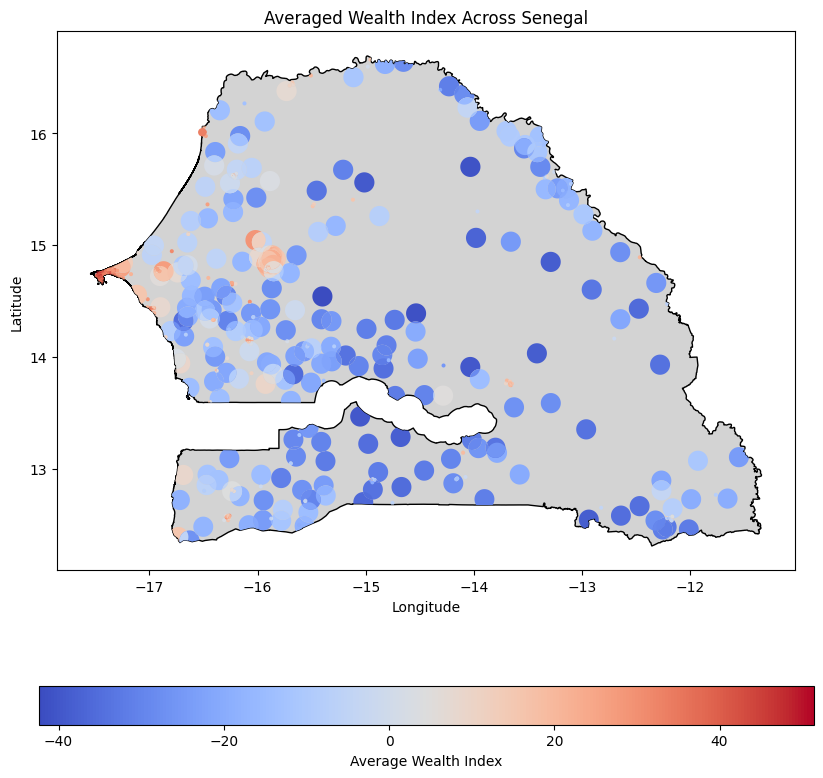

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Senegal boundary
senegal_boundary.plot(ax=ax, color="lightgray", edgecolor="black")

gdf_averaged.plot(
    column="wealth_index",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Average Wealth Index", "orientation": "horizontal"},
    edgecolor="none",
    cmap='coolwarm'
)

plt.title("Averaged Wealth Index Across Senegal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
###Trying an interactive map centered on Senegal
m = folium.Map(location=[14.5, -14], zoom_start=7)  # Center on Senegal
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row["LATNUM"], row["LONGNUM"]],
        radius=5,
        color="blue" if row["URBAN_RURA"] == "U" else "green",
        fill=True,
        fill_color="blue" if row["URBAN_RURA"] == "U" else "green",
        fill_opacity=0.6,
        popup=f"Region: {row['hv001']} | Wealth Index: {row['wealth_index']}",
    ).add_to(m)

m.save("wealth_index_map.html")